In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import boto3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import io
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from PIL import Image, UnidentifiedImageError

class S3ImageGenerator(Sequence):
    def __init__(self, bucket, prefix, split=True, batch_size=32, target_size=(299, 299), class_mode='binary', subset='training', split_ratio=0.9):
        self.s3 = boto3.client('s3')
        self.bucket = bucket
        self.prefix = prefix
        self.split = split
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.subset = subset
        all_keys, all_labels = self._gather_keys_labels()
        self.index = 0
        # Splitting the data
        if split:
            keys_train, keys_val, labels_train, labels_val = train_test_split(
                all_keys, all_labels, test_size=(1 - split_ratio), random_state=42)

            if self.subset == 'training':
                self.image_paths = keys_train
                self.labels = labels_train
            elif self.subset == 'validation':
                self.image_paths = keys_val
                self.labels = labels_val
        else:
            self.image_paths = all_keys
            self.labels = all_labels

    def _gather_keys_labels(self):
        keys = []
        labels = []
        paginator = self.s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=self.bucket, Prefix=self.prefix)
        for page in pages:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith('.jpg'):  # Ensure it's an image file
                    keys.append(key)
                    parts = key.split('/')
                    if 'noncovid' in parts:
                        label = 0
                    elif 'covid' in parts:
                        label = 1
                    labels.append(label)
        return keys, labels

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array([
            self._load_image(path) for path in batch_x]), np.array(batch_y)
    def __iter__(self):
        return self

    def __next__(self):
        if self.index < len(self):
            result = self[self.index]
            self.index += 1
            return result
        else:
            self.index = 0
            raise StopIteration
            
    def _load_image(self, path):
#         response = self.s3.get_object(Bucket=self.bucket, Key=path)
#         image_content = response['Body'].read()
#         image = Image.open(io.BytesIO(image_content))
#         image = image.resize(self.target_size, Image.Resampling.LANCZOS)
#         image = np.array(image)
#         if image.ndim == 2:
#             image = np.stack((image,) * 3, axis=-1)
#         elif image.shape[2] == 1:  # Single channel
#             image = np.concatenate((image, image, image), axis=-1)
#         image = image / 255.0  # Normalize pixel values
#         return image
        try:
            response = self.s3.get_object(Bucket=self.bucket, Key=path)
            image_content = response['Body'].read()
            image = Image.open(io.BytesIO(image_content))
            image = image.resize(self.target_size, Image.LANCZOS)
            image = np.array(image)
            if image.ndim == 2:
                image = np.stack((image,) * 3, axis=-1)
            elif image.shape[2] == 1:  # Single channel
                image = np.concatenate((image, image, image), axis=-1)
            image = image / 255.0  # Normalize pixel values
            return image
        except UnidentifiedImageError:
            print(f"Could not identify image file {path}")
            return None
bucket = 'covid19-ct-scan-proj'
prefix = 'validation' 
test_generator = S3ImageGenerator(bucket, prefix, split=False, subset='validation', split_ratio=0.9)


2024-08-13 15:35:25.915744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 15:35:26.573124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 15:35:26.867107: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 15:35:26.869251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 15:35:27.356619: I tensorflow/core/platform/cpu_feature_gua

In [22]:
def slice_data_generator(generator, num_batches):
    return (data for i, data in enumerate(generator) if i < num_batches)

# Set the number of batches to include
num_batches = 2076

# Create the sliced generator
sliced_test_generator = slice_data_generator(test_generator, num_batches)



In [17]:
# Define the number of batches you want to consider
num_batches = 2076
batch_size = test_generator.batch_size
num_samples = num_batches * batch_size
print(num_samples)

66432


In [2]:
labels = test_generator.labels
print(len(labels))
print(np.unique(labels))

75532
[0 1]


In [3]:
labels = test_generator.labels

# Print the total number of labels
print("Total number of labels:", len(labels))

# Print unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} instances")


Total number of labels: 75532
Label 0: 40516 instances
Label 1: 35016 instances


In [2]:
from tensorflow.keras import Model,models
model = models.load_model("/home/ubuntu/covid19-ct-scan/project_app/models/model_15e.h5")

2024-08-13 15:35:51.202144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 15:35:51.698015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-13 15:35:51.702833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [18]:
# Use the sliced generator to predict
predictions = model.predict(sliced_test_generator, steps=num_batches)
# Convert probabilities to binary labels (assuming binary classification)
predicted_labels = (predictions > 0.5).astype(int)


2024-08-02 13:56:36.220570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


2076/2076 [==============================] - 4926s 2s/step
Could not identify image file validation/noncovid/38310_._9.jpg
Could not identify image file validation/noncovid/38311_._92.jpg


2024-08-02 15:18:29.934078: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (32,) + inhomogeneous part.
Traceback (most recent call last):

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/data_adapter.py", li

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Predict the probabilities
predictions = model.predict(test_generator)
# Convert probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

2024-08-13 15:36:26.846997: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


2361/2361 [==============================] - 6319s 3s/step


F1 Score: 0.7009829439323881
Accuracy: 0.7414340941587672
Precision: 0.7555614231962505
Recall: 0.6537582819282614


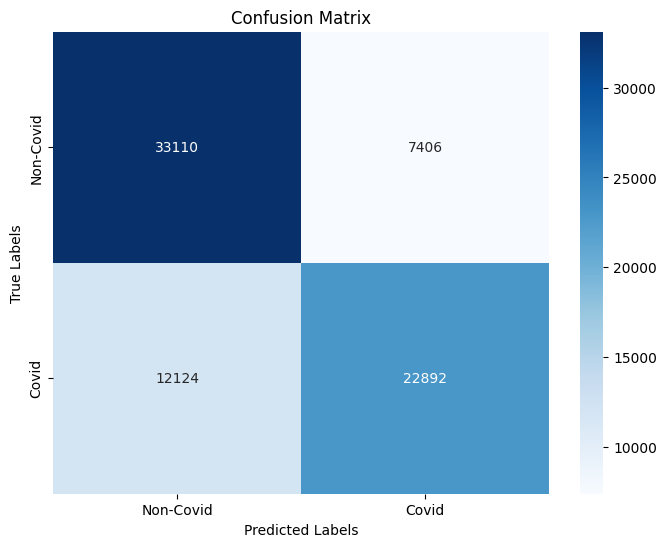

In [4]:
true_labels = test_generator.labels
# Slice the true labels accordingly
# limited_true_labels = true_labels[:num_samples]
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print("Recall:", recall)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Covid', 'Covid'], yticklabels=['Non-Covid', 'Covid'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



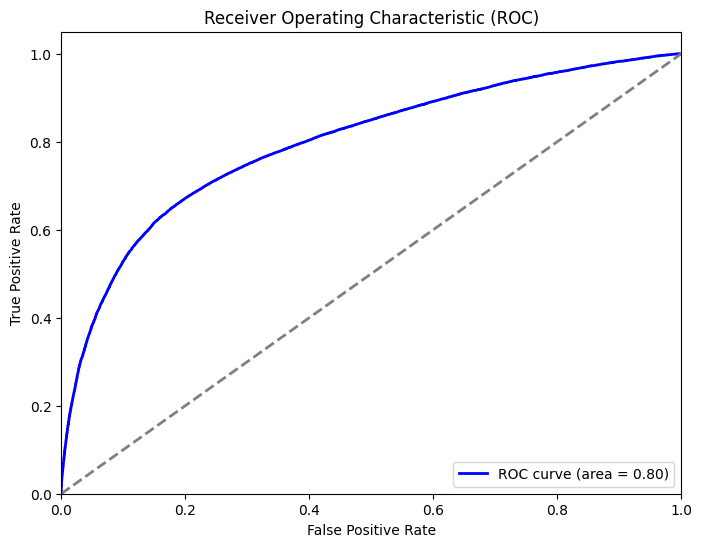

In [5]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random performance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()